## Pneumonia detection
This notebook presents some explaratory codes aimed at creating a computer-assisted diagnosis to assist radiologists in the detection of pneumonia on X-ray images.

In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from itertools import chain
from skimage import io

from sklearn.model_selection import train_test_split
from random import sample 
import scipy

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Keras learning rate finder
!git clone https://github.com/WittmannF/LRFinder.git
from LRFinder.keras_callback import LRFinder

from collections import Counter

Using TensorFlow backend.


fatal: destination path 'LRFinder' already exists and is not an empty directory.


In [ ]:
!ls /data/

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


In [ ]:
image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
image_paths

{'00019124_042.png': '/data/images_009/images/00019124_042.png',
 '00019576_024.png': '/data/images_009/images/00019576_024.png',
 '00019545_003.png': '/data/images_009/images/00019545_003.png',
 '00020065_000.png': '/data/images_009/images/00020065_000.png',
 '00020356_000.png': '/data/images_009/images/00020356_000.png',
 '00019962_003.png': '/data/images_009/images/00019962_003.png',
 '00018936_005.png': '/data/images_009/images/00018936_005.png',
 '00018562_007.png': '/data/images_009/images/00018562_007.png',
 '00020326_026.png': '/data/images_009/images/00020326_026.png',
 '00018704_000.png': '/data/images_009/images/00018704_000.png',
 '00020383_004.png': '/data/images_009/images/00020383_004.png',
 '00019576_021.png': '/data/images_009/images/00019576_021.png',
 '00019742_008.png': '/data/images_009/images/00019742_008.png',
 '00020326_018.png': '/data/images_009/images/00020326_018.png',
 '00020187_002.png': '/data/images_009/images/00020187_002.png',
 '00019847_004.png': '/da

In [ ]:
len(image_paths)

112120

In [ ]:
## Load the NIH data to all_xray_df_ori
all_xray_df_ori = pd.read_csv('/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df_ori.shape[0])

all_xray_df_ori['path'] = all_xray_df_ori['Image Index'].map(all_image_paths.get)

all_xray_df_ori.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
51448,00012998_001.png,No Finding,1,12998,33,F,PA,2048,2500,0.168,0.168,NaN,/data/images_006/images/00012998_001.png
71195,00017546_020.png,Atelectasis|Infiltration,20,17546,73,M,PA,2818,2991,0.143,0.143,NaN,/data/images_008/images/00017546_020.png
15974,00004238_003.png,No Finding,3,4238,19,M,PA,2500,2048,0.171,0.171,NaN,/data/images_003/images/00004238_003.png


In [ ]:
# drop the last column since it only has null values
# create a copy of the dataframe to preserve the original data for future reference
all_xray_df = all_xray_df_ori.copy()
all_xray_df = all_xray_df.dropna(axis=1)

# rename column names to match sample_df.
all_xray_df = all_xray_df.rename(columns = {'OriginalImage[Width':'OriginalImageWidth',
                              'Height]':'OriginalImageHeight', 
                              'OriginalImagePixelSpacing[x':'OriginalImagePixelSpacing_x',
                              'y]':'OriginalImagePixelSpacing_y'
                             })
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,/data/images_001/images/00000003_000.png


In [ ]:
## Here I'm going to split up my "Finding Labels" column so that I have one column per disease in my dataframe,
# with a binary flag (0 for Yes; 1 for No). This makes EDA a lot easier! 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for i in all_labels:
    if len(i) > 1: # leave out empty labels
        all_xray_df[i] = all_xray_df['Finding Labels'].map(lambda x: 1.0 if i in x else 0)

all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
68034,00016797_015.png,Consolidation|Effusion|Pneumothorax,15,16797,74,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44330,00011402_022.png,Atelectasis,22,11402,62,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24112,00006332_001.png,No Finding,1,6332,47,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: int(x))
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
43952,00011347_001.png,Emphysema,1,11347,79,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
88077,00021785_000.png,No Finding,0,21785,31,F,PA,2850,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
102952,00027441_025.png,Effusion|Nodule,25,27441,11,F,PA,2992,2989,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [ ]:
# calculate % of pneumonia cases in the dataset
np.sum(all_xray_df['pneumonia_class'])/len(all_xray_df)*100

1.2763110952550838

## Create training and testing data split

In [ ]:
def create_splits(df, col, val_pct=0.5):
    # col = 'Pneumonia'
    train_df, val_df = train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df[col])
    
    # our train_test_split made sure that we had the same proportions of pneumonia in both sets!
    # But.... we know that we want our model to be trained on a set that has equal proportions of pneumonia
    # and non-pneumonia, so we're going to have to throw away some data
    
    # train
    # We randomly chose a set of non-Pneumonia images using the sample() function that was the same length 
    # as the number of true Pneumonia cases we had, and then we threw out the rest of the non-Pneumonia cases 
    # so that our training dataset is balanced 50-50.
    pneumonia_idx = train_df[train_df[col]==1].index.tolist()
    nonpneumonia_idx = train_df[train_df[col]==0].index.tolist()

    nonpneumonia_sample = sample(nonpneumonia_idx, len(pneumonia_idx))
    train_df = train_df.loc[pneumonia_idx + nonpneumonia_sample]
    
    print('% pneumonia in train:', train_df[col].sum()/len(train_df))

    # validation
    pneumonia_idx = val_df[val_df[col]==1].index.tolist()
    nonpneumonia_idx = val_df[val_df[col]==0].index.tolist()

    if val_pct == 0.5:
        nonpneumonia_sample = sample(nonpneumonia_idx, len(pneumonia_idx))
    elif val_pct == 0.8:
        # if we assume the prevalence of Pneumothorax in this clinical situation is about 20%,
        # we may want to make the balance in our validation set = 20-80.
        # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample
        nonpneumonia_sample = sample(nonpneumonia_idx, 4*len(pneumonia_idx))

    
    val_df = val_df.loc[pneumonia_idx + nonpneumonia_sample]
    
    print('% pneumonia in val:', val_df[col].sum()/len(val_df))
    
    return train_df, val_df

In [ ]:
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

% pneumonia in train: 0.5
% pneumonia in val: 0.2


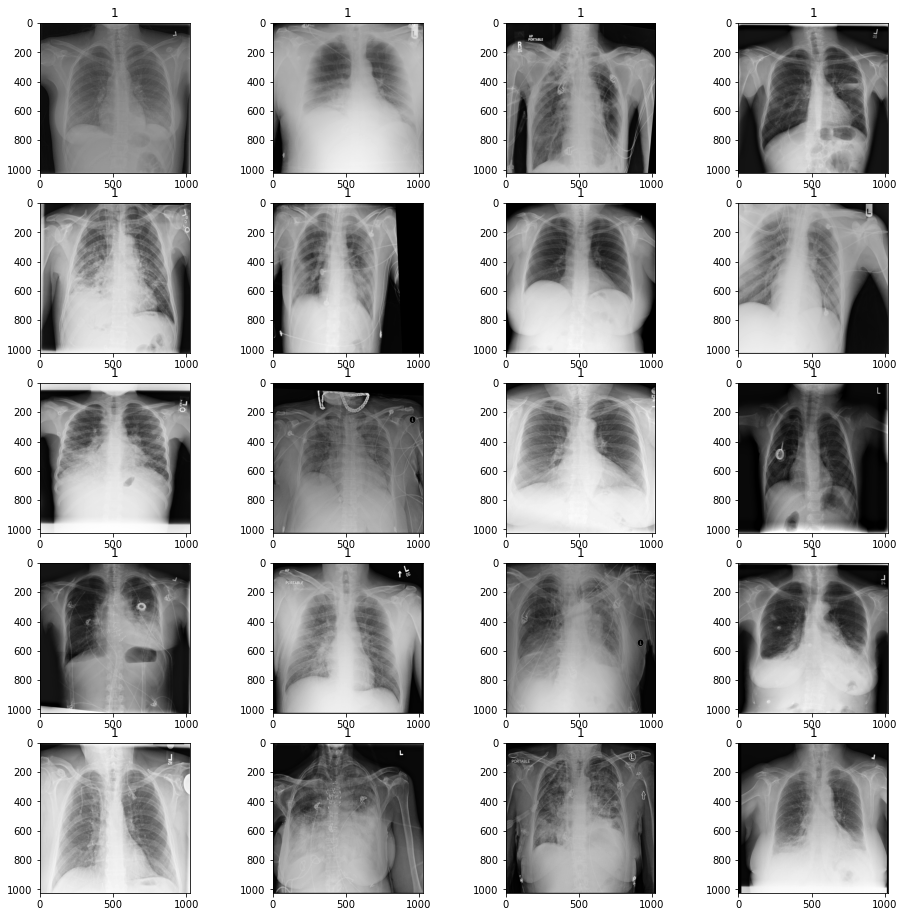

In [ ]:
# Create a figure with subplots and has a maximum axis: m-axis
fig, m_axs = plt.subplots(5,4, figsize = (16, 16))

# Return a copy of the array collapsed into one dimension.
m_axs = m_axs.flatten()
imgs = train_df.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(train_df.iloc[ind]['pneumonia_class'])
    ind=ind+1

# Perform image augmentation

In [ ]:
def my_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False,
                              zoom_range = 0.2)
    
    return my_idg


def make_train_gen(train_data, IMG_SIZE):
    ## Create the actual generators using the output of my_image_augmentation for your training data
    
    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = my_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen


def make_val_gen(val_data, IMG_SIZE):
    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}

    val_data['image_path'] = val_data['Image Index'].apply(lambda x: image_paths[x])
    
    val_data['pneumonia_class'] = val_data['pneumonia_class'].astype(str)
    
    # minimal augmentation is done on the validation dataset to emulate real life situation. We will keep 
    # my_image_augmentation() as the only augmentation performed on the validation dataset in this notebook
    my_val_idg = my_image_augmentation()
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return val_gen

In [ ]:
## resize images during augmentation - handy when wanting to do deep learning using a pre-trained CNN 
# that has a specified size for the input layer
IMG_SIZE = (224, 224) 

train_gen = make_train_gen(train_df, IMG_SIZE)
val_gen = make_val_gen(val_df, IMG_SIZE)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [ ]:
## pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

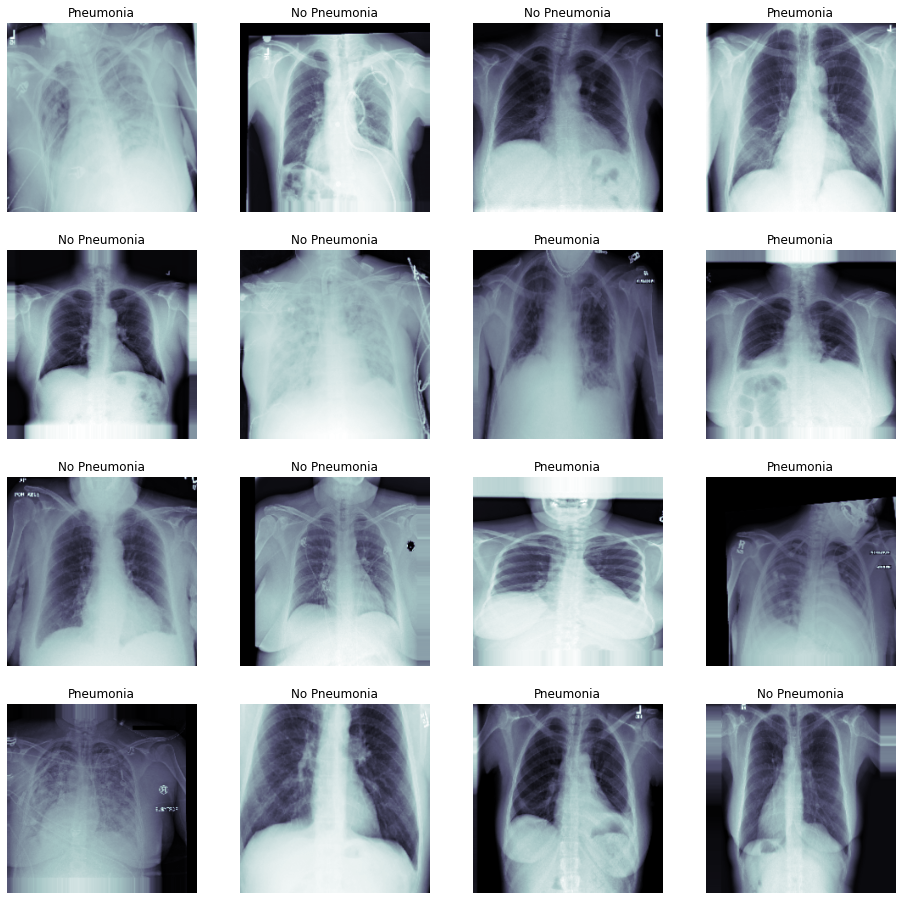

In [ ]:
## look at some examples of augmented training data
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Model building: 

Use a pre-trained network downloaded from Keras for fine-tuning

In [ ]:
def load_pretrained_model(vargs):
    # We'll load in VGG16 with pre-trained ImageNet weights:
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model

vgg_model = load_pretrained_model('imagenet')

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# MODEL 1

In [ ]:
def build_my_model1(vargs):
       
    new_model = Sequential()

    # ....add pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flattee, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model 
    # you want to freeze before you compile 
    
    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

In [ ]:
# freeze some layers in VGG16
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

## run a few epochs to see how it does:
my_model1 = build_my_model1(vgg_model)

my_model1.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 10)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Epoch 1/10
36/36 [==============================] - 69s 2s/step - loss: 0.6766 - binary_accuracy: 0.5751 - val_loss: 0.7581 - val_binary_accuracy: 0.5000
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6456 - binary_accuracy: 0.6354 - val_loss: 0.7767 - val_binary_accuracy: 0.5312
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6304 - binary_accuracy: 0.6563 - val_loss: 0.7192 - val_binary_accuracy: 0.5312
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6125 - binary_accuracy: 0.6725 - val_loss: 0.7918 - val_binary_accuracy: 0.5000
Epoch 5/10
36/36 [=================

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score, f1_score

def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
    
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
    print('F1 score:', 2*(precision*recall)/(precision+recall))
    
def plot_f1(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    f1_scores = []
    thresholds = []
    max_f1 = 0
    best_threshold = None
    for t in np.arange(0.0,1,0.01):        
        y_pred_class = p_y > t
        f1 = f1_score(t_y, y_pred_class)
        if max_f1 < f1:
            max_f1 = f1
            best_threshold = t
        f1_scores.append(f1)
        thresholds.append(t)
    
    c_ax.plot(thresholds, f1_scores,
              label = '%s (Best F1 Score:%0.2f with threshold %.2f)'  % ('Pneumonia', max_f1, best_threshold))
    c_ax.legend()
    c_ax.set_xlabel('threshold')
    c_ax.set_ylabel('f1')

64/64 [==============================] - 3s 55ms/step


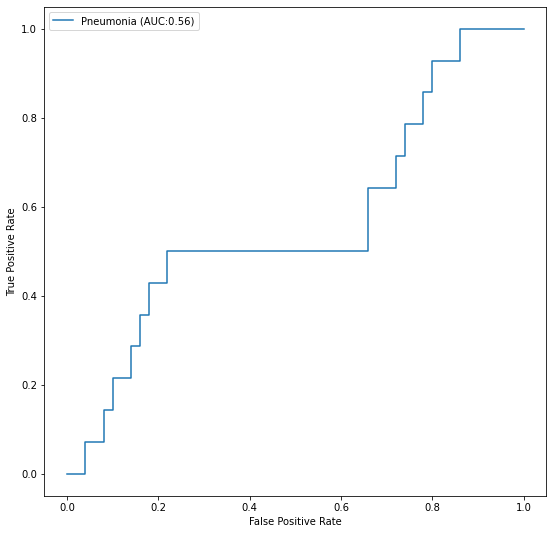

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


F1 score: [0.3943662  0.37142857 0.37681159 0.38235294 0.3880597  0.36363636
 0.36923077 0.34375    0.34920635 0.35483871 0.32786885 0.33333333
 0.30508475 0.31034483 0.31578947 0.32142857 0.29090909 0.25925926
 0.26415094 0.26923077 0.2745098  0.28       0.28571429 0.29166667
 0.29787234 0.30434783 0.31111111 0.31818182 0.3255814  0.33333333
 0.34146341 0.35       0.35897436 0.36842105 0.37837838 0.38888889
 0.4        0.41176471 0.42424242 0.4375     0.38709677 0.4
 0.4137931  0.35714286 0.37037037 0.30769231 0.32       0.25
 0.26086957 0.27272727 0.19047619 0.2        0.10526316 0.11111111
 0.11764706        nan        nan 0.        ]


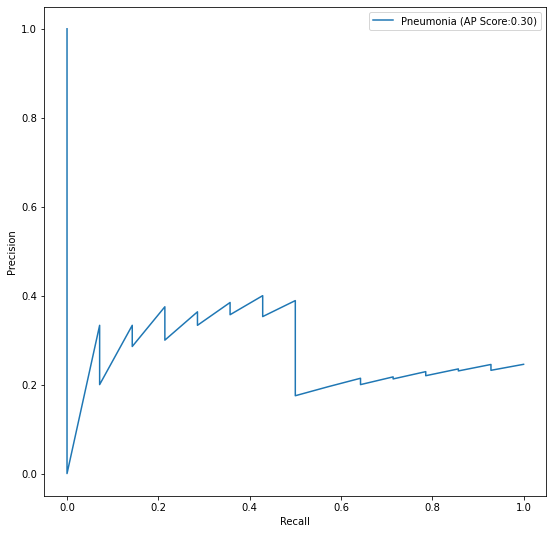

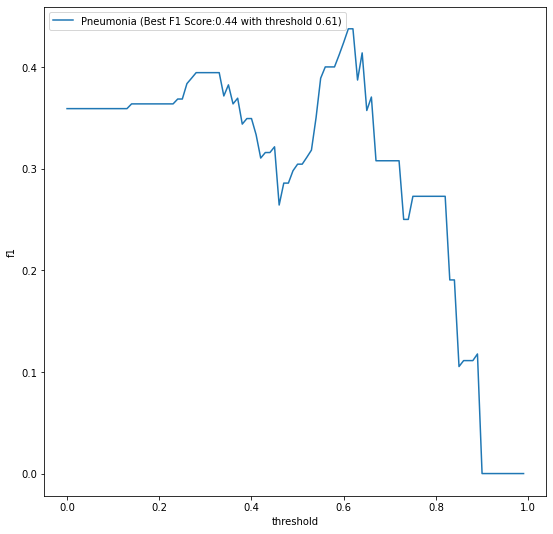

In [ ]:
pred_Y1 = my_model1.predict(valX, batch_size = 32, verbose = True)

t_y = valY
p_y = pred_Y1

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

### Image augmentation (training data)

Augmentation #0: rescale 

In [ ]:
def no_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    return my_idg


def make_train_gen_no_aug(train_data, IMG_SIZE):
    
    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = no_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen = make_train_gen_no_aug(train_df, IMG_SIZE)
val_gen = make_val_gen(val_df, IMG_SIZE)

valX, valY = val_gen.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f0v8 = build_my_model1(vgg_model)

my_model_f0v8.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 43s 1s/step - loss: 0.6761 - binary_accuracy: 0.5777 - val_loss: 0.5946 - val_binary_accuracy: 0.6719
Epoch 2/10
36/36 [==============================] - 37s 1s/step - loss: 0.5930 - binary_accuracy: 0.6934 - val_loss: 0.7111 - val_binary_accuracy: 0.5625
Epoch 3/10
36/36 [==============================] - 36s 1s/step - loss: 0.5452 - binary_accuracy: 0.7415 - val_loss: 0.6108 - val_binary_accuracy: 0.7031
Epoch 4/10
36/36 [==============================] - 37s 1s/step - loss: 0.5049 - binary_accuracy: 0.7803 - val_loss: 0.6861 - val_binary_accuracy: 0.5938
Epoch 5/10
36/36 [==============================] - 36s 1s/step - loss: 0.4696 - binary_accuracy: 0.8105 - val_loss: 0.7303 - val_binary_accuracy: 0.5938
Epoch 6/10
36/36 [==============================] - 37s 1s

64/64 [==============================] - 1s 10ms/step


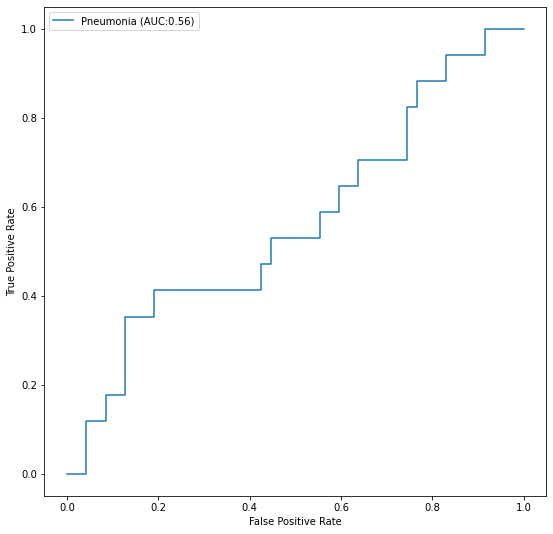

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


F1 score: [0.44155844 0.42105263 0.42666667 0.43243243 0.43835616 0.44444444
 0.42253521 0.42857143 0.43478261 0.44117647 0.41791045 0.42424242
 0.4        0.375      0.38095238 0.38709677 0.39344262 0.4
 0.40677966 0.37931034 0.38596491 0.39285714 0.36363636 0.37037037
 0.37735849 0.34615385 0.35294118 0.36       0.36734694 0.375
 0.38297872 0.34782609 0.35555556 0.31818182 0.3255814  0.33333333
 0.34146341 0.35       0.35897436 0.36842105 0.37837838 0.38888889
 0.4        0.41176471 0.42424242 0.375      0.38709677 0.4
 0.4137931  0.35714286 0.2962963  0.23076923 0.24       0.25
 0.17391304 0.18181818 0.19047619 0.1               nan        nan
 0.        ]


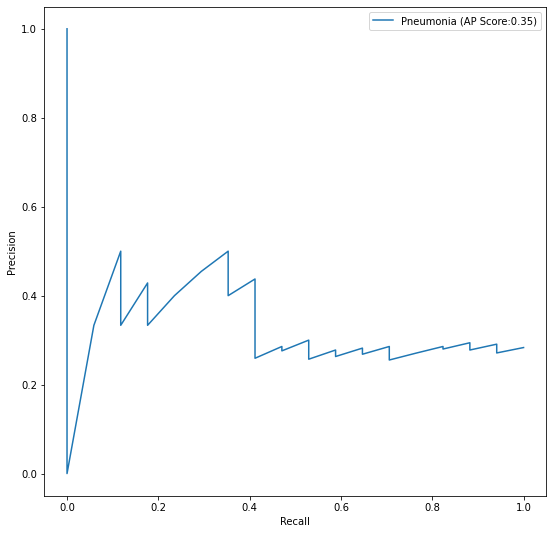

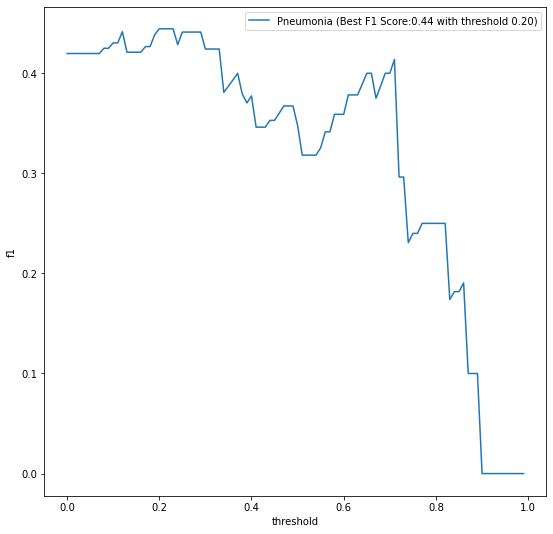

In [ ]:
pred_Y_f0v8 = my_model_f0v8.predict(valX, batch_size = 32, verbose = True)

t_y = valY
p_y = pred_Y_f0v8

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Augmentation #1: rescale + horizontal_flip = True

In [ ]:
def one_image_augmentation():

    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False)
#                               height_shift_range= 0.1, 
#                               width_shift_range=0.1, 
#                               rotation_range=15, 
#                               shear_range = 0.1,
#                               zoom_range=0.1)
    
    return my_idg


def make_train_gen_one_aug(train_data, IMG_SIZE):

    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = one_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_one_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f1 = build_my_model1(vgg_model)

my_model_f1.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 43s 1s/step - loss: 0.7138 - binary_accuracy: 0.5585 - val_loss: 0.6876 - val_binary_accuracy: 0.5625
Epoch 2/10
36/36 [==============================] - 37s 1s/step - loss: 0.6231 - binary_accuracy: 0.6568 - val_loss: 0.7331 - val_binary_accuracy: 0.5312
Epoch 3/10
36/36 [==============================] - 37s 1s/step - loss: 0.5929 - binary_accuracy: 0.6821 - val_loss: 0.6554 - val_binary_accuracy: 0.6094
Epoch 4/10
36/36 [==============================] - 37s 1s/step - loss: 0.5715 - binary_accuracy: 0.7000 - val_loss: 0.6362 - val_binary_accuracy: 0.6094
Epoch 5/10
36/36 [==============================] - 37s 1s/step - loss: 0.5472 - binary_accuracy: 0.7236 - val_loss: 0.7151 - val_binary_accuracy: 0.5312
Epoch 6/10
36/36 [==============================] - 37s 1s

64/64 [==============================] - 1s 10ms/step


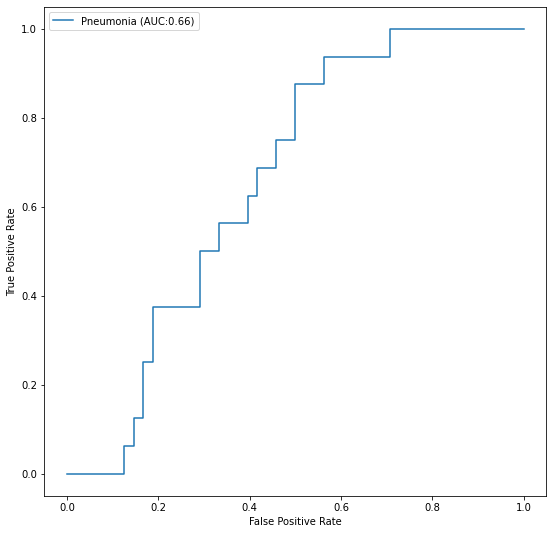

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


F1 score: [0.48484848 0.46153846 0.46875    0.47619048 0.48387097 0.49180328
 0.5        0.50847458 0.51724138 0.49122807 0.5        0.50909091
 0.51851852 0.49056604 0.46153846 0.47058824 0.48       0.44897959
 0.45833333 0.46808511 0.43478261 0.44444444 0.40909091 0.41860465
 0.42857143 0.43902439 0.4        0.41025641 0.42105263 0.37837838
 0.33333333 0.34285714 0.35294118 0.36363636 0.375      0.38709677
 0.33333333 0.27586207 0.28571429 0.22222222 0.15384615 0.16
 0.08333333 0.08695652        nan        nan        nan        nan
        nan        nan 0.        ]


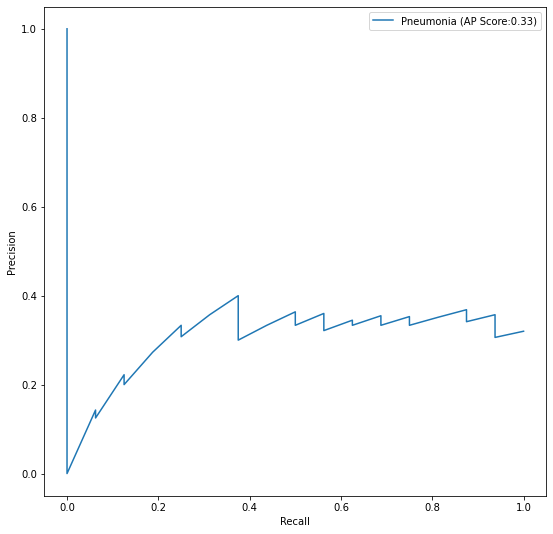

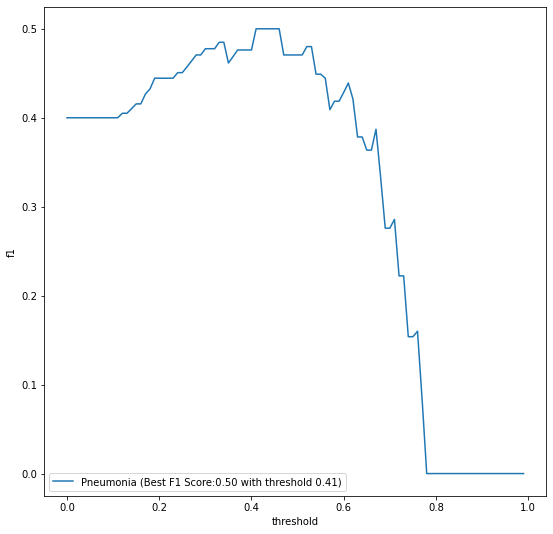

In [ ]:
pred_Y_f1 = my_model_f1.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f1

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Augmentation #2: rescale + horizontal_flip + height_shift_range= 0.1

In [ ]:
def two_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1)
#                               width_shift_range=0.1, 
#                               rotation_range=15, 
#                               shear_range = 0.1,
#                               zoom_range=0.1)
    
    return my_idg


def make_train_gen_two_aug(train_data, IMG_SIZE):

    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = two_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_two_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f2 = build_my_model1(vgg_model)

my_model_f2.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 0.7228 - binary_accuracy: 0.5620 - val_loss: 0.7770 - val_binary_accuracy: 0.4844
Epoch 2/10
36/36 [==============================] - 59s 2s/step - loss: 0.6509 - binary_accuracy: 0.6188 - val_loss: 0.4779 - val_binary_accuracy: 0.7969
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6458 - binary_accuracy: 0.6279 - val_loss: 0.7504 - val_binary_accuracy: 0.5312
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6007 - binary_accuracy: 0.6821 - val_loss: 0.6005 - val_binary_accuracy: 0.6875
Epoch 5/10
36/36 [==============================] - 59s 2s/step - loss: 0.5877 - binary_accuracy: 0.6952 - val_loss: 0.6854 - val_binary_accuracy: 0.6094
Epoch 6/10
36/36 [==============================] - 59s 2s

64/64 [==============================] - 1s 10ms/step


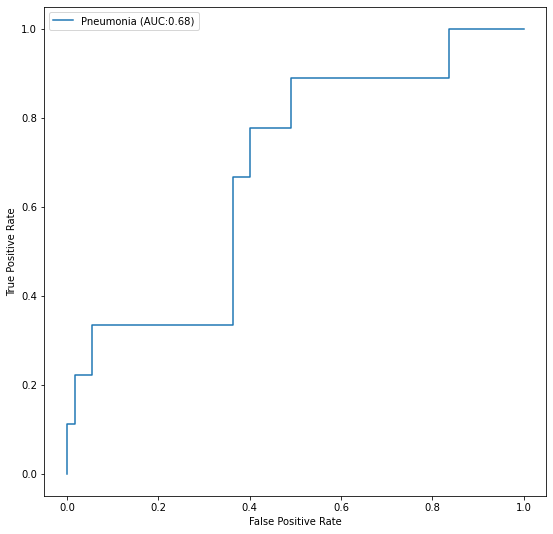

F1 score: [0.28125    0.25396825 0.25806452 0.26229508 0.26666667 0.27118644
 0.27586207 0.28070175 0.28571429 0.29090909 0.2962963  0.30188679
 0.30769231 0.31372549 0.32       0.32653061 0.33333333 0.34042553
 0.34782609 0.35555556 0.36363636 0.3255814  0.33333333 0.34146341
 0.35       0.35897436 0.36842105 0.32432432 0.33333333 0.34285714
 0.29411765 0.24242424 0.1875     0.19354839 0.2        0.20689655
 0.21428571 0.22222222 0.23076923 0.24       0.25       0.26086957
 0.27272727 0.28571429 0.3        0.31578947 0.33333333 0.35294118
 0.375      0.4        0.28571429 0.30769231 0.33333333 0.18181818
 0.2        0.        ]


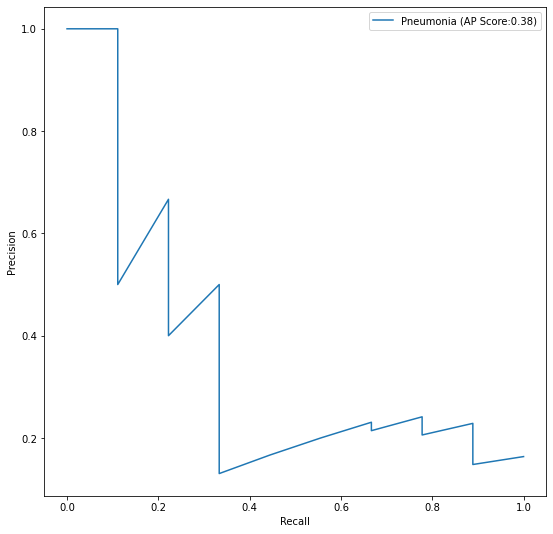

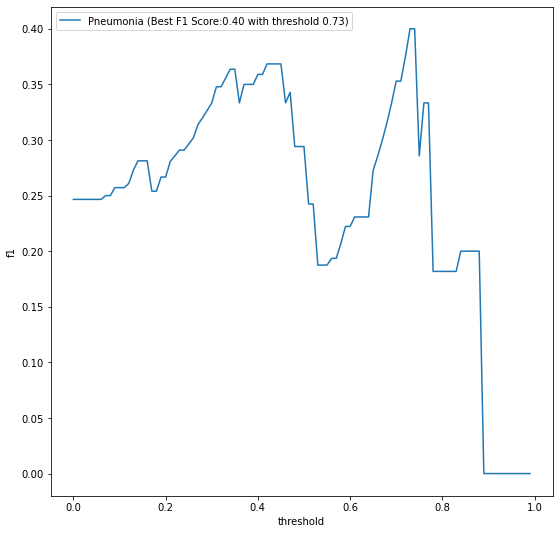

In [ ]:
pred_Y_f2 = my_model_f2.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f2

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Augmentation #3: rescale + horizontal_flip + height_shift_range + width_shift_range = 0.1

In [ ]:
def three_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1,
                              width_shift_range=0.1) 
#                               rotation_range=15, 
#                               shear_range = 0.1,
#                               zoom_range=0.1)
    
    return my_idg


def make_train_gen_three_aug(train_data, IMG_SIZE):
    
    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = three_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_three_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f3 = build_my_model1(vgg_model)

my_model_f3.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 64s 2s/step - loss: 0.6997 - binary_accuracy: 0.5563 - val_loss: 0.8612 - val_binary_accuracy: 0.3906
Epoch 2/10
36/36 [==============================] - 58s 2s/step - loss: 0.6553 - binary_accuracy: 0.6114 - val_loss: 0.6841 - val_binary_accuracy: 0.5625
Epoch 3/10
36/36 [==============================] - 58s 2s/step - loss: 0.6357 - binary_accuracy: 0.6472 - val_loss: 0.6667 - val_binary_accuracy: 0.6094
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6195 - binary_accuracy: 0.6668 - val_loss: 0.7502 - val_binary_accuracy: 0.5312
Epoch 5/10
36/36 [==============================] - 59s 2s/step - loss: 0.6157 - binary_accuracy: 0.6620 - val_loss: 0.6425 - val_binary_accuracy: 0.6562
Epoch 6/10
36/36 [==============================] - 58s 2s

64/64 [==============================] - 1s 9ms/step


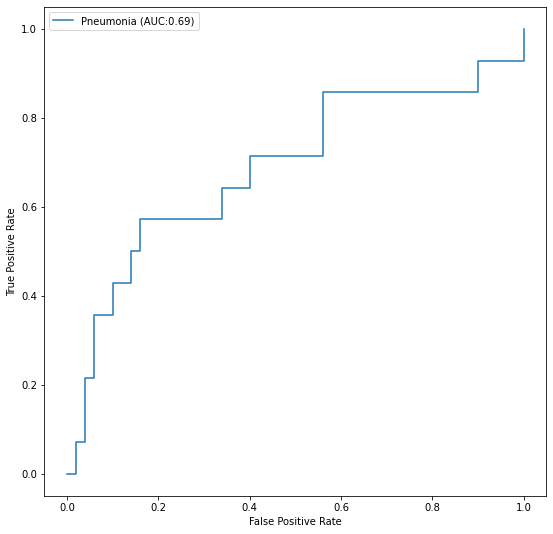

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


F1 score: [0.35897436 0.33766234 0.34210526 0.34666667 0.35135135 0.35616438
 0.36111111 0.33802817 0.34285714 0.34782609 0.35294118 0.35820896
 0.36363636 0.36923077 0.375      0.38095238 0.38709677 0.39344262
 0.4        0.40677966 0.4137931  0.42105263 0.42857143 0.43636364
 0.44444444 0.41509434 0.38461538 0.39215686 0.4        0.40816327
 0.41666667 0.42553191 0.43478261 0.44444444 0.45454545 0.41860465
 0.42857143 0.43902439 0.45       0.41025641 0.42105263 0.43243243
 0.44444444 0.45714286 0.47058824 0.48484848 0.5        0.51612903
 0.53333333 0.48275862 0.5        0.44444444 0.46153846 0.48
 0.41666667 0.43478261 0.45454545 0.38095238 0.3        0.31578947
 0.22222222 0.11764706 0.125             nan 0.        ]


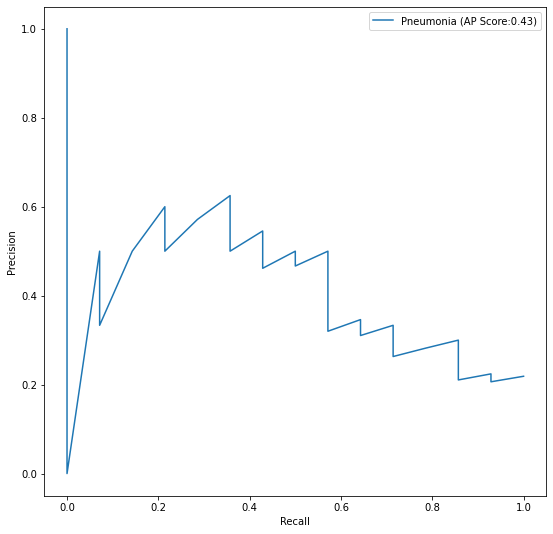

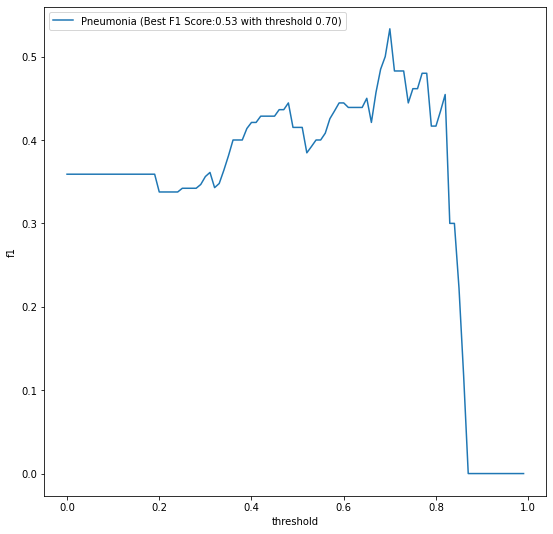

In [ ]:
pred_Y_f3 = my_model_f3.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f3

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Augmentation #4: rescale + horizontal_flip + height_shift_range + rotation_range = 5

In [ ]:
def four_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1,
#                               width_shift_range=0.1, 
                              rotation_range=5) 
#                               shear_range = 0.1,
#                               zoom_range=0.1)
    
    return my_idg


def make_train_gen_four_aug(train_data, IMG_SIZE):

    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = four_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_four_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f4 = build_my_model1(vgg_model)

my_model_f4.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 63s 2s/step - loss: 0.6751 - binary_accuracy: 0.5891 - val_loss: 0.6433 - val_binary_accuracy: 0.5781
Epoch 2/10
36/36 [==============================] - 59s 2s/step - loss: 0.6393 - binary_accuracy: 0.6240 - val_loss: 0.6131 - val_binary_accuracy: 0.6406
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6207 - binary_accuracy: 0.6629 - val_loss: 0.6469 - val_binary_accuracy: 0.6719
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.5972 - binary_accuracy: 0.6873 - val_loss: 0.6806 - val_binary_accuracy: 0.6094
Epoch 5/10
36/36 [==============================] - 59s 2s/step - loss: 0.5788 - binary_accuracy: 0.7109 - val_loss: 0.7195 - val_binary_accuracy: 0.5312
Epoch 6/10
36/36 [==============================] - 59s 2s

64/64 [==============================] - 1s 9ms/step


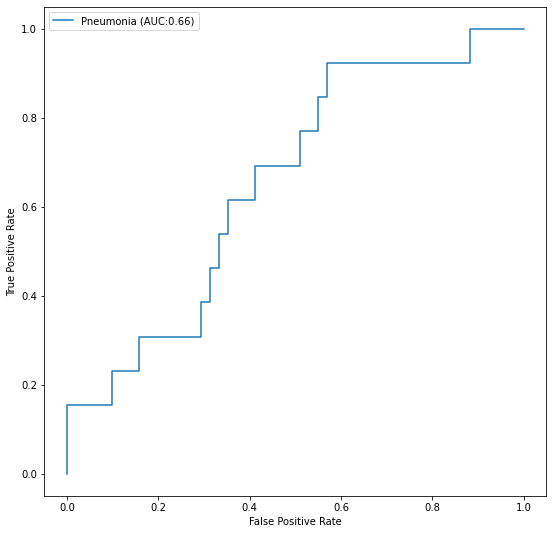

F1 score: [0.36619718 0.34285714 0.34782609 0.35294118 0.35820896 0.36363636
 0.36923077 0.375      0.38095238 0.38709677 0.39344262 0.4
 0.40677966 0.4137931  0.42105263 0.42857143 0.43636364 0.44444444
 0.41509434 0.42307692 0.39215686 0.4        0.40816327 0.375
 0.38297872 0.39130435 0.4        0.40909091 0.41860465 0.38095238
 0.3902439  0.4        0.41025641 0.36842105 0.37837838 0.33333333
 0.34285714 0.29411765 0.3030303  0.25       0.25806452 0.26666667
 0.27586207 0.28571429 0.2962963  0.30769231 0.32       0.25
 0.26086957 0.27272727 0.28571429 0.2        0.21052632 0.22222222
 0.23529412 0.25       0.26666667 0.14285714 0.        ]


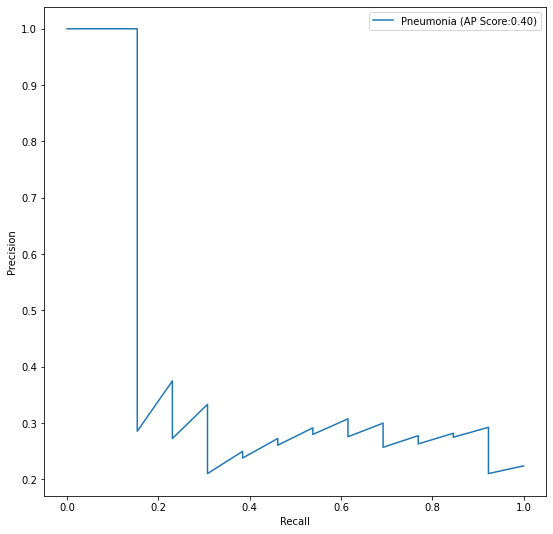

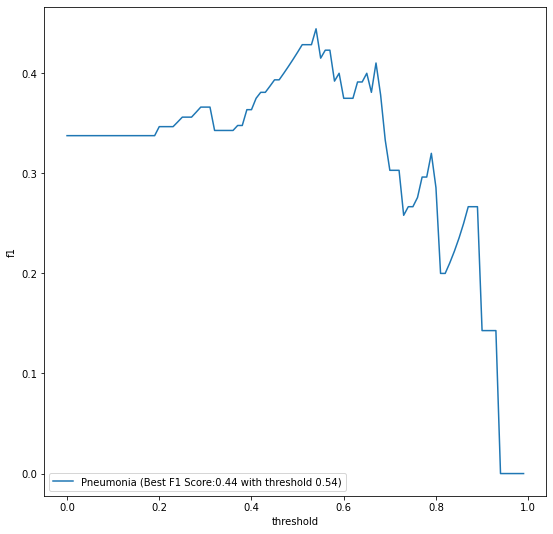

In [ ]:
pred_Y_f4 = my_model_f4.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f4

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Augmentation #5: rescale + horizontal_flip + height_shift_range + zoom_range = 0.25

In [ ]:
def five_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1,
#                               width_shift_range=0.1, 
#                               rotation_range=5, 
#                               shear_range = 0.1,
                              zoom_range=0.25)
    
    return my_idg


def make_train_gen_five_aug(train_data, IMG_SIZE):

    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = five_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_five_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f5 = build_my_model1(vgg_model)

my_model_f5.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 64s 2s/step - loss: 0.6921 - binary_accuracy: 0.5747 - val_loss: 0.6118 - val_binary_accuracy: 0.6250
Epoch 2/10
36/36 [==============================] - 59s 2s/step - loss: 0.6378 - binary_accuracy: 0.6402 - val_loss: 0.6431 - val_binary_accuracy: 0.6875
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6335 - binary_accuracy: 0.6568 - val_loss: 0.7225 - val_binary_accuracy: 0.5625
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6364 - binary_accuracy: 0.6459 - val_loss: 0.5096 - val_binary_accuracy: 0.7500
Epoch 5/10
36/36 [==============================] - 59s 2s/step - loss: 0.6329 - binary_accuracy: 0.6397 - val_loss: 0.5469 - val_binary_accuracy: 0.7188
Epoch 6/10
36/36 [==============================] - 59s 2s

64/64 [==============================] - 1s 10ms/step


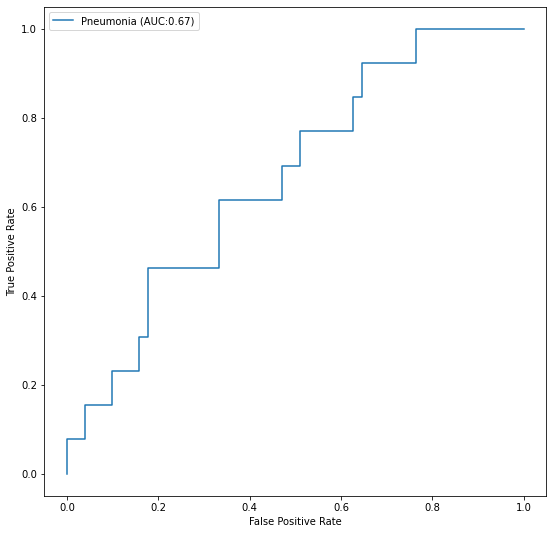

F1 score: [0.4        0.375      0.38095238 0.38709677 0.39344262 0.4
 0.40677966 0.4137931  0.38596491 0.39285714 0.36363636 0.37037037
 0.37735849 0.38461538 0.39215686 0.4        0.40816327 0.375
 0.38297872 0.39130435 0.35555556 0.36363636 0.37209302 0.38095238
 0.3902439  0.4        0.41025641 0.42105263 0.37837838 0.33333333
 0.34285714 0.35294118 0.36363636 0.375      0.38709677 0.4
 0.4137931  0.42857143 0.37037037 0.30769231 0.32       0.25
 0.26086957 0.27272727 0.28571429 0.2        0.21052632 0.22222222
 0.23529412 0.125      0.13333333 0.14285714 0.        ]


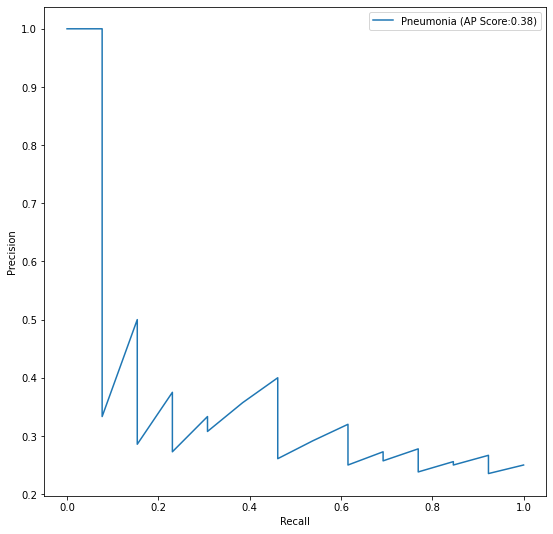

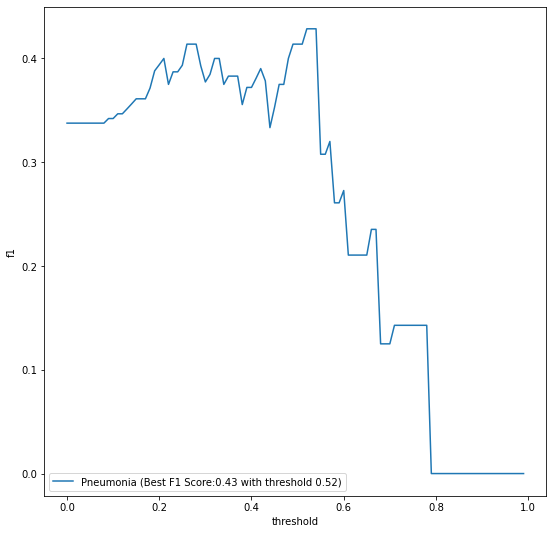

In [ ]:
pred_Y_f5 = my_model_f5.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f5

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Augmentation #6: rescale + horizontal_flip + height_shift_range + zoom_range = 0.1

In [ ]:
def six_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1,
#                               width_shift_range=0.1, 
#                               rotation_range=5, 
#                               shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen_six_aug(train_data, IMG_SIZE):
    
    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = six_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_six_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f6 = build_my_model1(vgg_model)

my_model_f6.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 64s 2s/step - loss: 0.6794 - binary_accuracy: 0.5900 - val_loss: 0.6567 - val_binary_accuracy: 0.5469
Epoch 2/10
36/36 [==============================] - 58s 2s/step - loss: 0.6394 - binary_accuracy: 0.6301 - val_loss: 0.7870 - val_binary_accuracy: 0.4688
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6304 - binary_accuracy: 0.6463 - val_loss: 0.7288 - val_binary_accuracy: 0.5156
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6125 - binary_accuracy: 0.6581 - val_loss: 0.7731 - val_binary_accuracy: 0.5000
Epoch 5/10
36/36 [==============================] - 59s 2s/step - loss: 0.5998 - binary_accuracy: 0.6808 - val_loss: 0.7183 - val_binary_accuracy: 0.5469
Epoch 6/10
36/36 [==============================] - 60s 2s

64/64 [==============================] - 1s 10ms/step


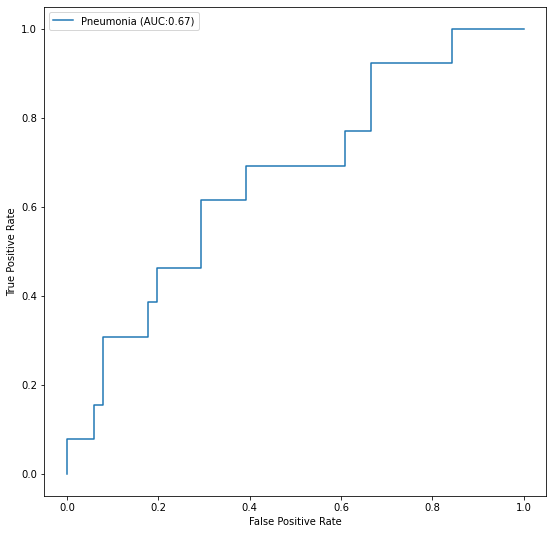

F1 score: [0.37681159 0.35294118 0.35820896 0.36363636 0.36923077 0.375
 0.38095238 0.38709677 0.39344262 0.4        0.40677966 0.37931034
 0.35087719 0.35714286 0.36363636 0.37037037 0.33962264 0.34615385
 0.35294118 0.36       0.36734694 0.375      0.38297872 0.39130435
 0.4        0.40909091 0.41860465 0.42857143 0.3902439  0.4
 0.41025641 0.42105263 0.43243243 0.44444444 0.4        0.35294118
 0.36363636 0.375      0.38709677 0.4        0.4137931  0.35714286
 0.37037037 0.30769231 0.32       0.33333333 0.34782609 0.36363636
 0.38095238 0.3        0.21052632 0.22222222 0.11764706 0.125
 0.13333333 0.14285714 0.        ]


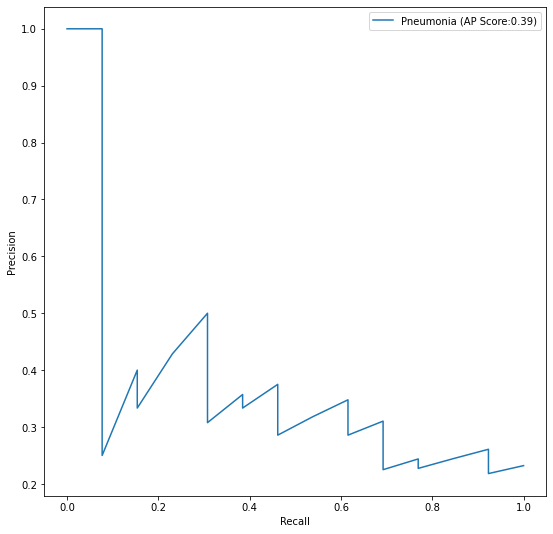

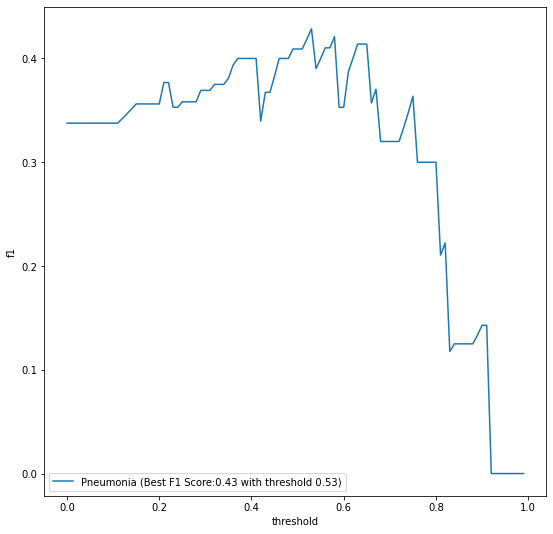

In [ ]:
pred_Y_f6 = my_model_f6.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f6

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Augmentation #7: rescale + horizontal_flip + height_shift_range + width_shift_range + rotation_range + zoom_range

In [ ]:
def seven_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1,
                              width_shift_range=0.1, 
                              rotation_range=5, 
#                               shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen_seven_aug(train_data, IMG_SIZE):
    
    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = seven_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_seven_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f7 = build_my_model1(vgg_model)

my_model_f7.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 0.6711 - binary_accuracy: 0.5965 - val_loss: 0.5964 - val_binary_accuracy: 0.7500
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6365 - binary_accuracy: 0.6288 - val_loss: 0.5092 - val_binary_accuracy: 0.7969
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6258 - binary_accuracy: 0.6638 - val_loss: 0.4548 - val_binary_accuracy: 0.8281
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6077 - binary_accuracy: 0.6655 - val_loss: 0.6360 - val_binary_accuracy: 0.7188
Epoch 5/10
36/36 [==============================] - 59s 2s/step - loss: 0.6091 - binary_accuracy: 0.6699 - val_loss: 0.4107 - val_binary_accuracy: 0.8281
Epoch 6/10
36/36 [==============================] - 59s 2s

64/64 [==============================] - 1s 9ms/step


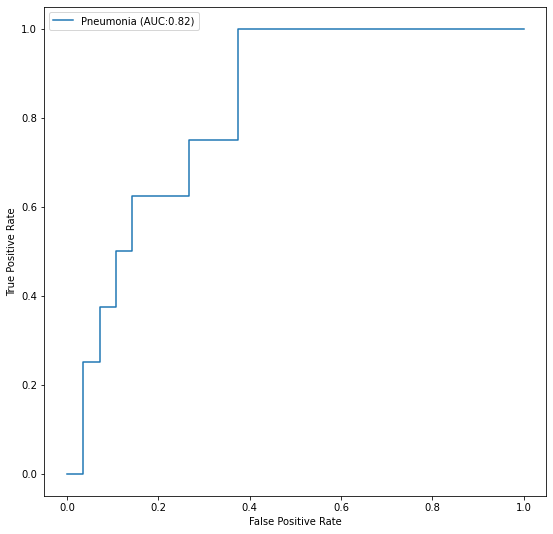

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


F1 score: [0.43243243 0.38888889 0.34285714 0.35294118 0.36363636 0.375
 0.38709677 0.4        0.4137931  0.35714286 0.37037037 0.38461538
 0.4        0.41666667 0.43478261 0.45454545 0.47619048 0.4
 0.42105263 0.44444444 0.35294118 0.375      0.4        0.28571429
 0.30769231 0.33333333 0.18181818        nan        nan 0.        ]


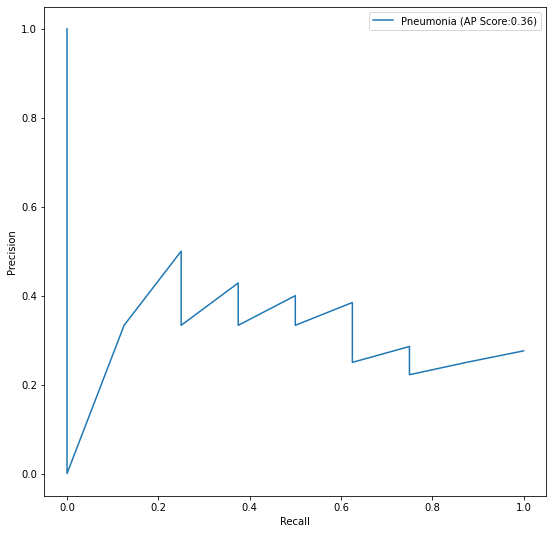

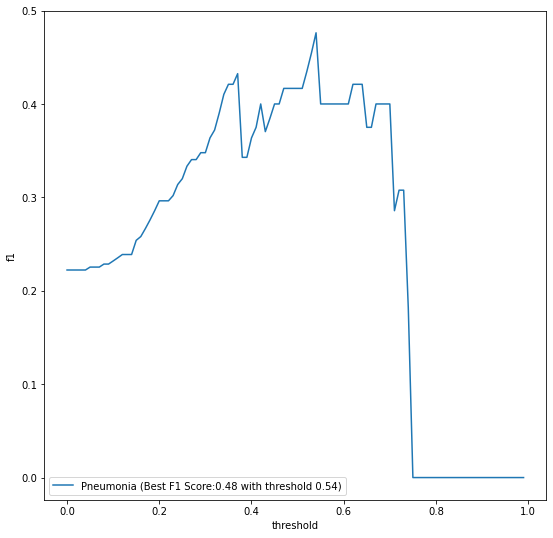

In [ ]:
pred_Y_f7 = my_model_f7.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f7

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Augmentation #8: rescale + horizontal_flip + height_shift_range + width_shift_range + rotation_range + shear_range + zoom_range

In [ ]:
def eight_image_augmentation():
    '''
    horizontal_flip and vertical_flip should be set to True/False
    height_shift_range and width_shift_range should be between 0 and 1
    rotation_range can be between 0 and 180
    shear_range can be between 0 and 1
    zoom_range can be between 0 and 1
    '''
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1,
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              zoom_range=0.25)
    
    return my_idg


def make_train_gen_eight_aug(train_data, IMG_SIZE):
    
    # create column for image_path    
    image_paths = {os.path.basename(x): x for x in glob(os.path.join('/data','images*', '*', '*.png'))}
    train_data['image_path'] = train_data['Image Index'].apply(lambda x: image_paths[x])
    
    # this line (convert to string) is added to pacify TypeError: If class_mode="binary", y_col="pneumonia_class" column values must be strings.
    train_data['pneumonia_class'] = train_data['pneumonia_class'].astype(str)
    
    my_train_idg = eight_image_augmentation()
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data,  
                                                 directory=None, 
                                                 x_col = 'image_path',  
                                                 y_col ='pneumonia_class', 
                                                 class_mode = 'binary',  
                                                 target_size = IMG_SIZE,      
                                                 batch_size = 64     
                                                )
    return train_gen

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f8 = build_my_model1(vgg_model)

my_model_f8.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 66s 2s/step - loss: 0.6782 - binary_accuracy: 0.5786 - val_loss: 0.6508 - val_binary_accuracy: 0.6562
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6562 - binary_accuracy: 0.6266 - val_loss: 0.5633 - val_binary_accuracy: 0.7188
Epoch 3/10
36/36 [==============================] - 61s 2s/step - loss: 0.6477 - binary_accuracy: 0.6384 - val_loss: 0.6128 - val_binary_accuracy: 0.6719
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6439 - binary_accuracy: 0.6284 - val_loss: 0.6500 - val_binary_accuracy: 0.6406
Epoch 5/10
36/36 [==============================] - 60s 2s/step - loss: 0.6445 - binary_accuracy: 0.6223 - val_loss: 0.6047 - val_binary_accuracy: 0.7188
Epoch 6/10
36/36 [==============================] - 59s 2s

64/64 [==============================] - 1s 10ms/step


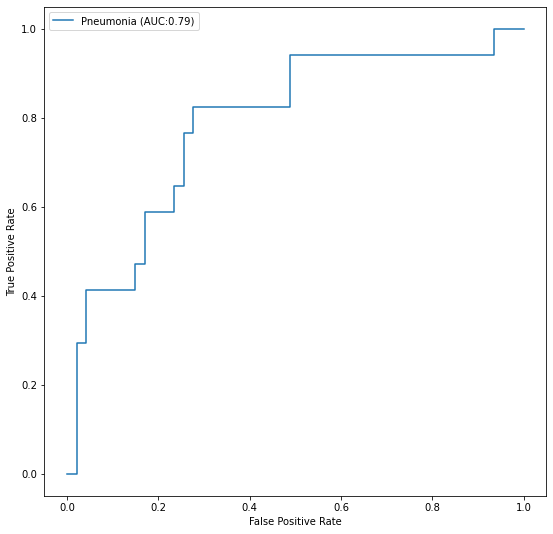

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


F1 score: [0.43589744 0.41558442 0.42105263 0.42666667 0.43243243 0.43835616
 0.44444444 0.45070423 0.45714286 0.46376812 0.47058824 0.47761194
 0.48484848 0.49230769 0.5        0.50793651 0.51612903 0.52459016
 0.53333333 0.54237288 0.55172414 0.56140351 0.57142857 0.54545455
 0.51851852 0.52830189 0.53846154 0.54901961 0.56       0.57142857
 0.58333333 0.59574468 0.60869565 0.62222222 0.63636364 0.60465116
 0.61904762 0.58536585 0.55       0.56410256 0.52631579 0.54054054
 0.55555556 0.57142857 0.52941176 0.48484848 0.5        0.4516129
 0.46666667 0.48275862 0.5        0.51851852 0.53846154 0.48
 0.41666667 0.43478261 0.36363636 0.28571429 0.2        0.10526316
        nan 0.        ]


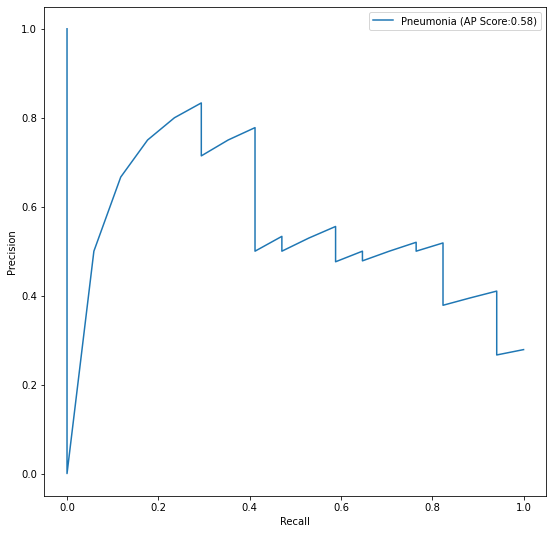

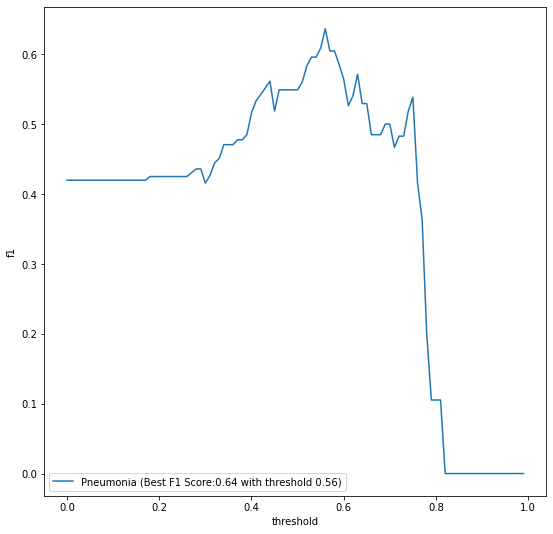

In [ ]:
pred_Y_f8 = my_model_f8.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f8

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

The best feature augmentation is Augmentation #8 (rescale + horizontal_flip + height_shift_range + width_shift_range + rotation_range + shear_range + zoom_range).

# Finding maximum learning rate

In [ ]:
# same model, change optimizer to one without a learning rate (i.e. SGD) in order to find the maximum learning rate for Adam

def build_my_model2(vargs):
       
    new_model = Sequential()

    # ....add pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flattee, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model 
    # you want to freeze before you compile 
    
    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1, activation='sigmoid'))
    
    ## Set our optimizer, loss function, and learning rate
    optimizer = SGD()
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 0.7337 - binary_accuracy: 0.4943 - val_loss: 0.9094 - val_binary_accuracy: 0.2031
Epoch 2/10
36/36 [==============================] - 59s 2s/step - loss: 0.7355 - binary_accuracy: 0.4956 - val_loss: 0.9094 - val_binary_accuracy: 0.2031
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.7352 - binary_accuracy: 0.4961 - val_loss: 0.9089 - val_binary_accuracy: 0.2031
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.7369 - binary_accuracy: 0.5017 - val_loss: 0.9048 - val_binary_accuracy: 0.2031
Epoch 5/10
36/36 [==============================] - 59s 2s/step - loss: 0.7311 - binary_accuracy: 0.4974 - val_loss: 0.8787 - val_binary_accuracy: 0.2031
Epoch 6/10
36/36 [==============================] - 59s 2s

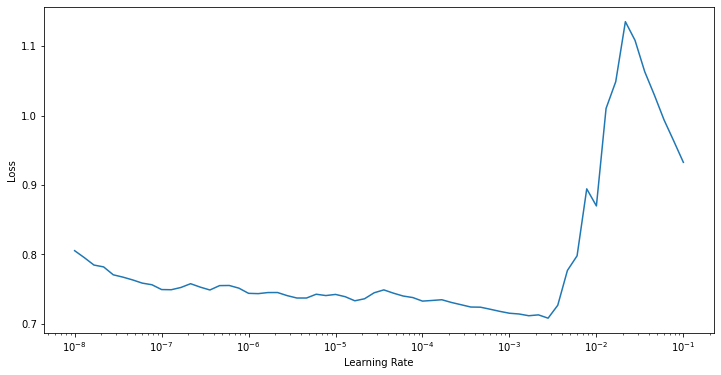

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f8_2 = build_my_model2(vgg_model)

# Fit using Callback
lr_finder = LRFinder(min_lr=1e-8, max_lr=1)

my_model_f8_2.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       callbacks=[lr_finder],
                       epochs = 10)

The optimal maximum learning rate to set is 1e-4, which was what was already used in the first model (build_my_model1).

### Adding class weights (in lieu of create_split())

In [ ]:
train_df, val_df = train_test_split(all_xray_df,
                                   test_size = 0.2, 
                                   stratify = all_xray_df['Pneumonia'])
IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen3 = make_val_gen(val_df, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f80 = build_my_model1(vgg_model)

counter = Counter(train_gen3.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

my_model_f80.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       class_weight=class_weights,
                       epochs = 5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Found 89696 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Found 22424 validated image filenames belonging to 2 classes.
Epoch 1/5
1402/1402 [==============================] - 2549s 2s/step - loss: 1.3686 - binary_accuracy: 0.5569 - val_loss: 0.8174 - val_binary_accuracy: 0.3125
Epoch 2/5
1402/1402 [==============================] - 2598s 2s/step - loss: 1.2985 - binary_accuracy: 0.6059 - val_loss: 0.7188 - val_binary_accuracy: 0.5312
Epoch 3/5
 166/1402 [==>...........................] - ETA: 38:12 - loss: 1.3110 - binary_accuracy: 0.6027

In [ ]:
my_model_f80_json = my_model_f80.to_json()
with open("my_model_f80_using_class_weights_full_dataset_5_epochs.json", "w") as json_file:
    json_file.write(best_model_diseased_json)
# serialize weights to HDF5
my_model_f80.save_weights("my_model_f80_using_class_weights_full_dataset_5_epochs.h5")
print("Saved model to disk")

In [ ]:
pred_Y_f80 = my_model_f80.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f80

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

The above codes could not be executed due to memory contraint.

### Adding class weights (with create_split())

In [ ]:
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen3 = make_val_gen(val_df, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f80_ = build_my_model1(vgg_model)

counter = Counter(train_gen3.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

my_model_f80_.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       class_weight=class_weights,
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 64s 2s/step - loss: 0.6728 - binary_accuracy: 0.5707 - val_loss: 0.6350 - val_binary_accuracy: 0.6719
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6324 - binary_accuracy: 0.6489 - val_loss: 0.6313 - val_binary_accuracy: 0.7031
Epoch 3/10
36/36 [==============================] - 59s 2s/step - loss: 0.6275 - binary_accuracy: 0.6507 - val_loss: 0.6590 - val_binary_accuracy: 0.6875
Epoch 4/10
36/36 [==============================] - 60s 2s/step - loss: 0.6140 - binary_accuracy: 0.6581 - val_loss: 0.5994 - val_binary_accuracy: 0.7188
Epoch 5/10
36/36 [==============================] - 60s 2s/step - loss: 0.6091 - binary_accuracy: 0.6677 - val_loss: 0.6878 - val_binary_accuracy: 0.6406
Epoch 6/10
36/36 [==============================] - 61s 2s

Saved model to disk
64/64 [==============================] - 1s 10ms/step


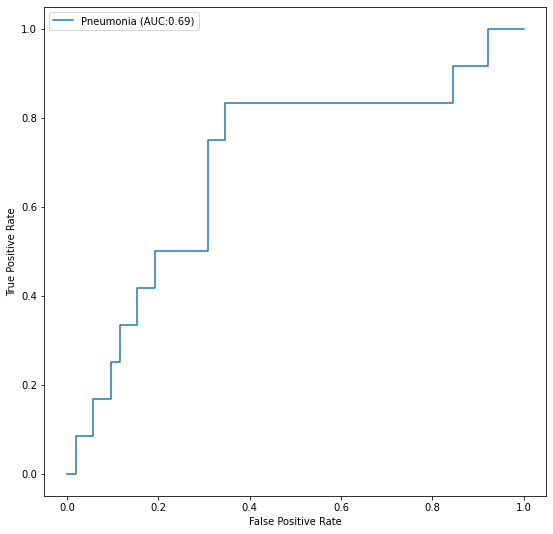

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


F1 score: [0.33333333 0.30985915 0.31428571 0.31884058 0.32352941 0.32835821
 0.3030303  0.30769231 0.3125     0.31746032 0.32258065 0.32786885
 0.33333333 0.33898305 0.34482759 0.35087719 0.35714286 0.36363636
 0.37037037 0.37735849 0.38461538 0.39215686 0.4        0.40816327
 0.41666667 0.42553191 0.43478261 0.44444444 0.45454545 0.46511628
 0.47619048 0.48780488 0.5        0.46153846 0.47368421 0.48648649
 0.44444444 0.4        0.35294118 0.36363636 0.375      0.38709677
 0.4        0.4137931  0.42857143 0.37037037 0.38461538 0.4
 0.33333333 0.34782609 0.36363636 0.28571429 0.3        0.21052632
 0.22222222 0.23529412 0.125      0.13333333 0.14285714        nan
 0.        ]


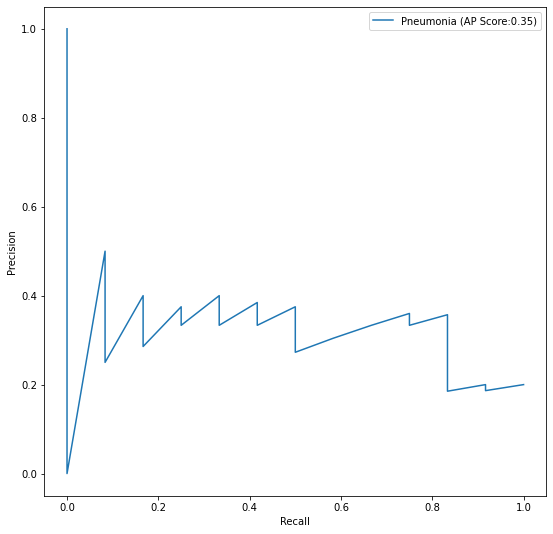

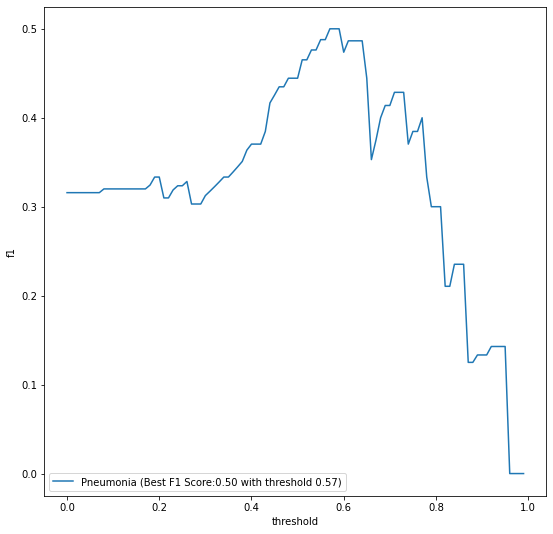

In [ ]:
pred_Y_f80_ = my_model_f80_.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f80_

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

## Add dense layers

In [ ]:
# add a few more dense layers
def build_my_model3(vargs):
    
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    ## Set our optimizer, loss function, and learning rate
    optimizer = SGD()
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 0.7100 - binary_accuracy: 0.5013 - val_loss: 0.5995 - val_binary_accuracy: 0.8438
Epoch 2/10
36/36 [==============================] - 62s 2s/step - loss: 0.7114 - binary_accuracy: 0.4983 - val_loss: 0.5995 - val_binary_accuracy: 0.8438
Epoch 3/10
36/36 [==============================] - 61s 2s/step - loss: 0.7123 - binary_accuracy: 0.4969 - val_loss: 0.5995 - val_binary_accuracy: 0.8438
Epoch 4/10
36/36 [==============================] - 62s 2s/step - loss: 0.7114 - binary_accuracy: 0.4974 - val_loss: 0.6000 - val_binary_accuracy: 0.8281
Epoch 5/10
36/36 [==============================] - 61s 2s/step - loss: 0.7096 - binary_accuracy: 0.4987 - val_loss: 0.6027 - val_binary_accuracy: 0.8281
Epoch 6/10
36/36 [==============================] - 61s 2s

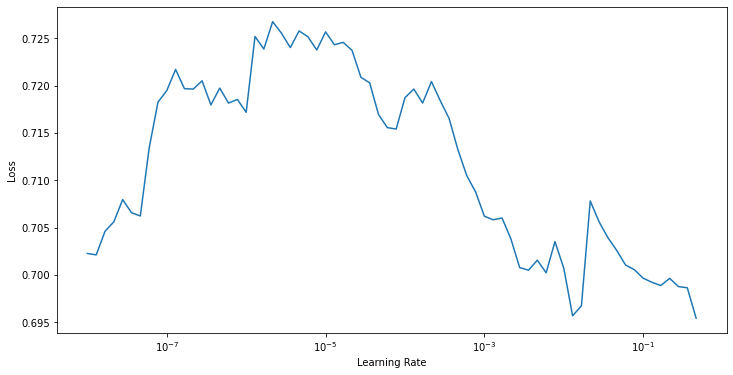

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f8_3 = build_my_model3(vgg_model)

# Fit using Callback
lr_finder = LRFinder(min_lr=1e-8, max_lr=1)

my_model_f8_3.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       callbacks=[lr_finder],
                       epochs = 10)

Set lr = 1e-2, 6e-1.

In [ ]:
# optimizer = Adam(lr=1e-2)
def build_my_model4_(vargs):
    
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=1e-2)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f8_4_ = build_my_model4_(vgg_model)

my_model_f8_4_.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 0.9876 - binary_accuracy: 0.5087 - val_loss: 0.6756 - val_binary_accuracy: 0.7656
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6964 - binary_accuracy: 0.4865 - val_loss: 0.6957 - val_binary_accuracy: 0.2344
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.6936 - binary_accuracy: 0.5017 - val_loss: 0.6854 - val_binary_accuracy: 0.7656
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6935 - binary_accuracy: 0.5000 - val_loss: 0.6873 - val_binary_accuracy: 0.7656
Epoch 5/10
36/36 [==============================] - 58s 2s/step - loss: 0.7719 - binary_accuracy: 0.4873 - val_loss: 0.6924 - val_binary_accuracy: 0.7656
Epoch 6/10
36/36 [==============================] - 59s 2s

64/64 [==============================] - 1s 10ms/step


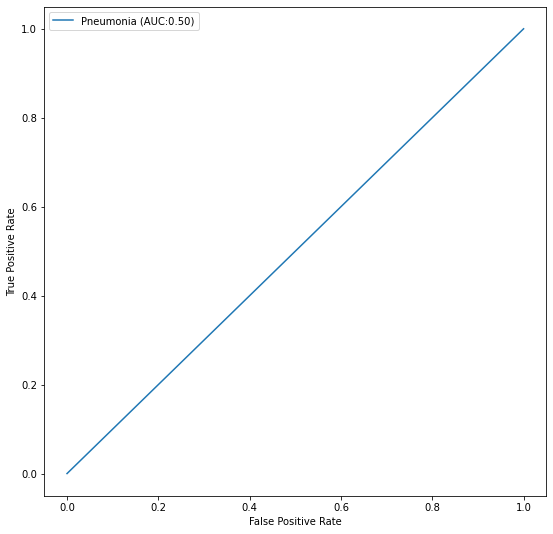

F1 score: [0.37974684 0.        ]


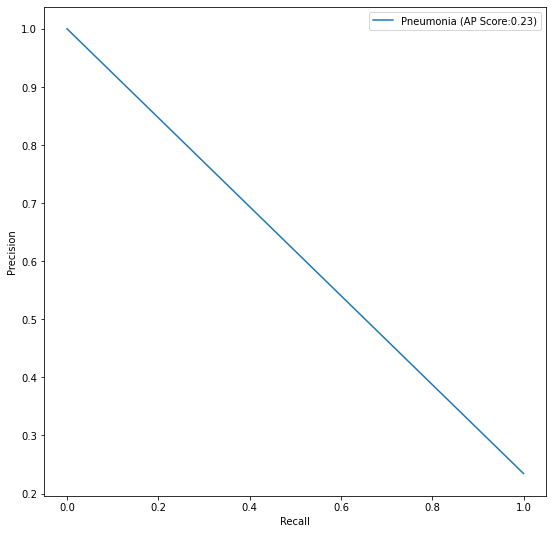

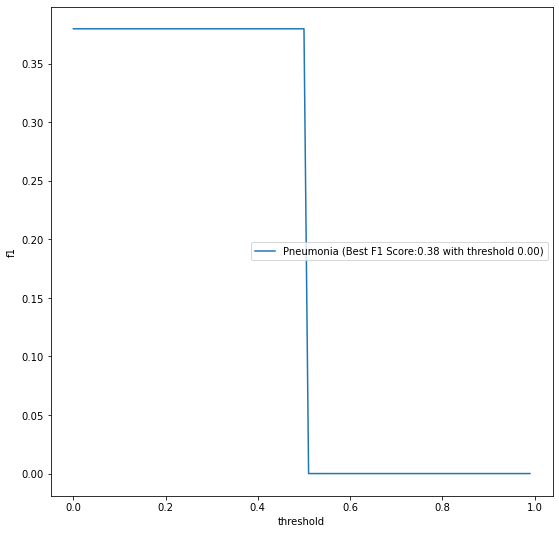

In [ ]:
pred_Y_f8_4_ = my_model_f8_4_.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f8_4_

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

In [ ]:
# optimizer = Adam(lr=6e-1)
def build_my_model4_2(vargs):
    
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=6e-1)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

In [ ]:
train_df3, val_df3 = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df3, IMG_SIZE)
val_gen3 = make_val_gen(val_df3, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f8_4_2 = build_my_model4_2(vgg_model)

my_model_f8_4_2.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 15.7139 - binary_accuracy: 0.5052 - val_loss: 0.6825 - val_binary_accuracy: 0.9062
Epoch 2/10
36/36 [==============================] - 61s 2s/step - loss: 0.7958 - binary_accuracy: 0.4983 - val_loss: 0.7162 - val_binary_accuracy: 0.0938
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 877.6057 - binary_accuracy: 0.4939 - val_loss: 275.7959 - val_binary_accuracy: 0.0938
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 97.9510 - binary_accuracy: 0.4948 - val_loss: 0.4915 - val_binary_accuracy: 0.9062
Epoch 5/10
36/36 [==============================] - 60s 2s/step - loss: 0.7025 - binary_accuracy: 0.4965 - val_loss: 0.7068 - val_binary_accuracy: 0.0938
Epoch 6/10
36/36 [==============================] - 

64/64 [==============================] - 1s 10ms/step


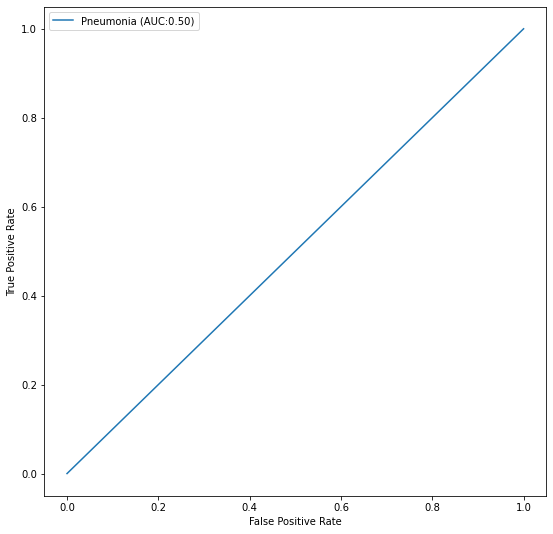

F1 score: [0.17142857 0.        ]


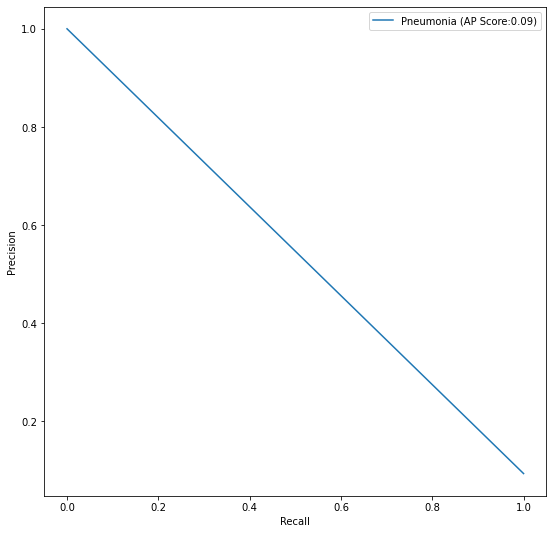

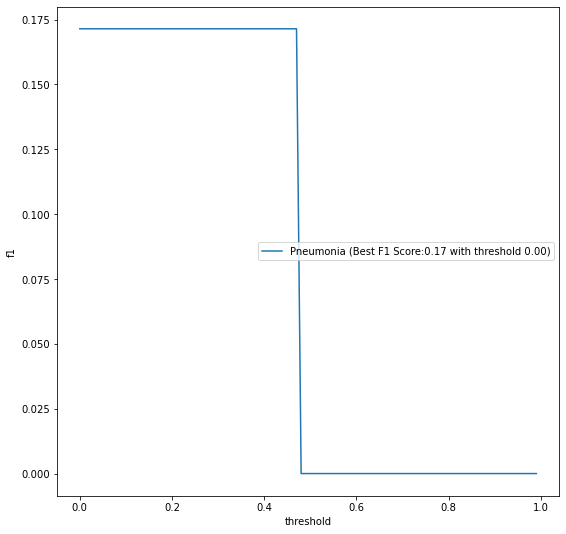

In [ ]:
pred_Y_f8_4_2 = my_model_f8_4_2.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f8_4_2

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 66s 2s/step - loss: 0.7042 - binary_accuracy: 0.5148 - val_loss: 0.7917 - val_binary_accuracy: 0.2188
Epoch 2/10
36/36 [==============================] - 61s 2s/step - loss: 0.7041 - binary_accuracy: 0.5074 - val_loss: 0.7917 - val_binary_accuracy: 0.2188
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.7094 - binary_accuracy: 0.4974 - val_loss: 0.7915 - val_binary_accuracy: 0.2188
Epoch 4/10
36/36 [==============================] - 60s 2s/step - loss: 0.7050 - binary_accuracy: 0.5004 - val_loss: 0.7894 - val_binary_accuracy: 0.2188
Epoch 5/10
36/36 [==============================] - 60s 2s/step - loss: 0.7043 - binary_accuracy: 0.5048 - val_loss: 0.7817 - val_binary_accuracy: 0.2344
Epoch 6/10
36/36 [==============================] - 61s 2s

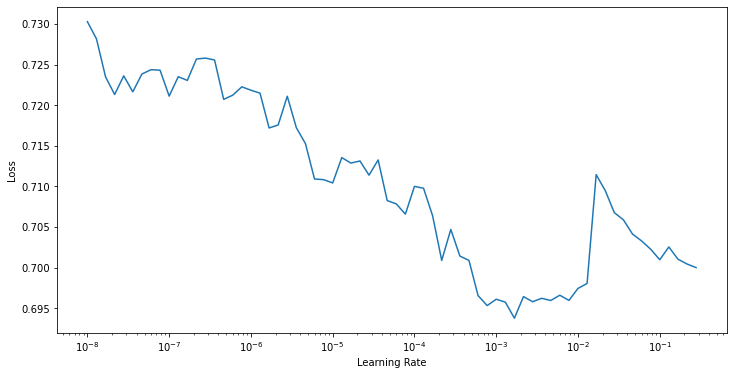

In [ ]:
# find optimal lr when using class_weights

train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen3 = make_val_gen(val_df, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f8_30 = build_my_model3(vgg_model)

counter = Counter(train_gen3.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

# Fit using Callback
lr_finder = LRFinder(min_lr=1e-8, max_lr=1)

my_model_f8_30.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       callbacks=[lr_finder],
                       class_weight=class_weights,
                       epochs = 10)

In [ ]:
# optimizer = Adam(lr=5e-3)
def build_my_model4(vargs):
    
    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(1024, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(lr=5e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']

    new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return new_model

In [ ]:
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen3 = make_val_gen(val_df, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f8_40 = build_my_model4(vgg_model)

counter = Counter(train_gen3.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

my_model_f8_40.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       class_weight=class_weights,
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/10
36/36 [==============================] - 66s 2s/step - loss: 26.8871 - binary_accuracy: 0.4996 - val_loss: 0.6871 - val_binary_accuracy: 0.8438
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6935 - binary_accuracy: 0.5000 - val_loss: 0.6907 - val_binary_accuracy: 0.8438
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.6933 - binary_accuracy: 0.4926 - val_loss: 0.6976 - val_binary_accuracy: 0.1562
Epoch 4/10
36/36 [==============================] - 59s 2s/step - loss: 0.6934 - binary_accuracy: 0.4904 - val_loss: 0.6937 - val_binary_accuracy: 0.1562
Epoch 5/10
36/36 [==============================] - 59s 2s/step - loss: 0.6959 - binary_accuracy: 0.5017 - val_loss: 0.6936 - val_binary_accuracy: 0.1562
Epoch 6/10
36/36 [==============================] - 60s 2

64/64 [==============================] - 1s 10ms/step


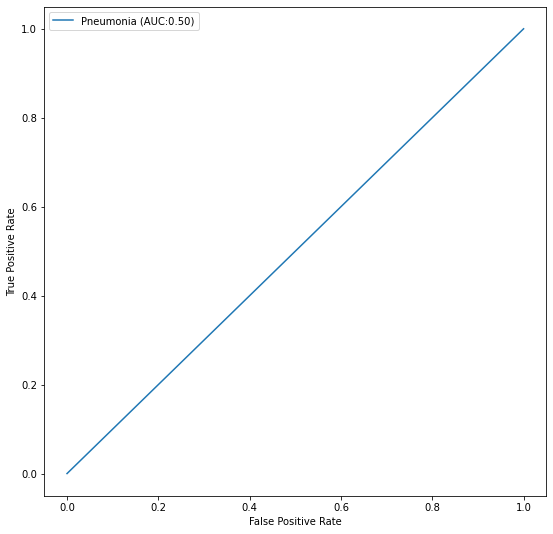

F1 score: [0.27027027 0.        ]


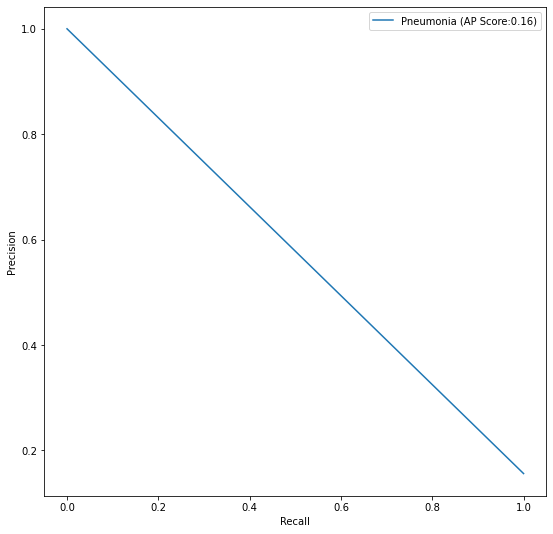

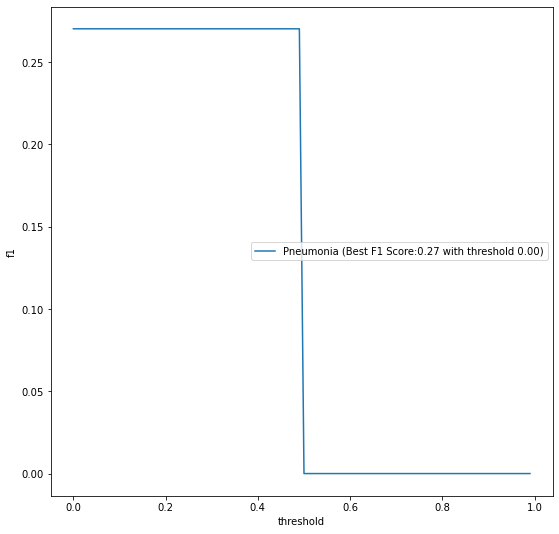

In [ ]:
pred_Y_f8_40 = my_model_f8_40.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f8_40

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Adding dense layers does not seem to contribute to an increase in the performance of the models.

### Increasing epochs

In [ ]:
# increase epochs = 25
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen3 = make_val_gen(val_df, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f80_1 = build_my_model1(vgg_model)

counter = Counter(train_gen3.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

my_model_f80_1.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       class_weight=class_weights,
                       epochs = 25)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/25
36/36 [==============================] - 63s 2s/step - loss: 0.6866 - binary_accuracy: 0.5664 - val_loss: 0.6486 - val_binary_accuracy: 0.7031
Epoch 2/25
36/36 [==============================] - 57s 2s/step - loss: 0.6737 - binary_accuracy: 0.6122 - val_loss: 0.6164 - val_binary_accuracy: 0.7031
Epoch 3/25
36/36 [==============================] - 57s 2s/step - loss: 0.6605 - binary_accuracy: 0.6179 - val_loss: 0.5836 - val_binary_accuracy: 0.7500
Epoch 4/25
36/36 [==============================] - 58s 2s/step - loss: 0.6503 - binary_accuracy: 0.6214 - val_loss: 0.5586 - val_binary_accuracy: 0.7500
Epoch 5/25
36/36 [==============================] - 57s 2s/step - loss: 0.6454 - binary_accuracy: 0.6253 - val_loss: 0.5964 - val_binary_accuracy: 0.7031
Epoch 6/25
36/36 [==============================] - 57s 2s

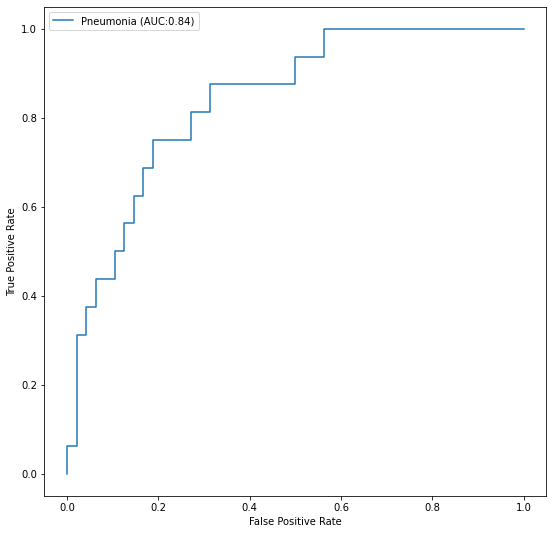

F1 score: [0.54237288 0.51724138 0.52631579 0.53571429 0.54545455 0.51851852
 0.52830189 0.53846154 0.54901961 0.56       0.57142857 0.58333333
 0.59574468 0.60869565 0.62222222 0.59090909 0.60465116 0.61904762
 0.58536585 0.6        0.61538462 0.63157895 0.64864865 0.61111111
 0.62857143 0.58823529 0.60606061 0.5625     0.58064516 0.53333333
 0.55172414 0.5        0.51851852 0.53846154 0.48       0.5
 0.43478261 0.45454545 0.38095238 0.3        0.21052632 0.11111111
 0.11764706 0.        ]


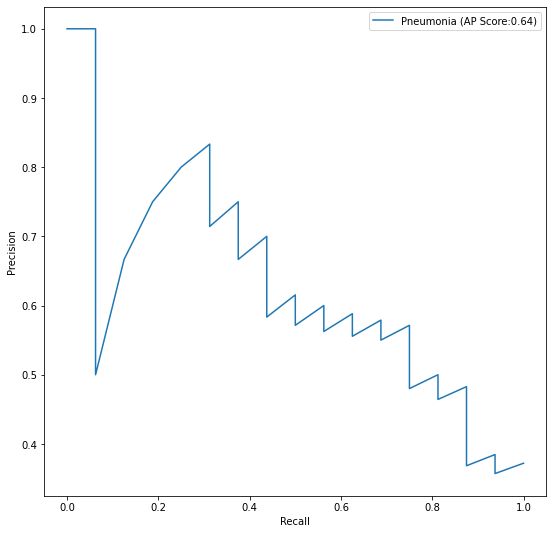

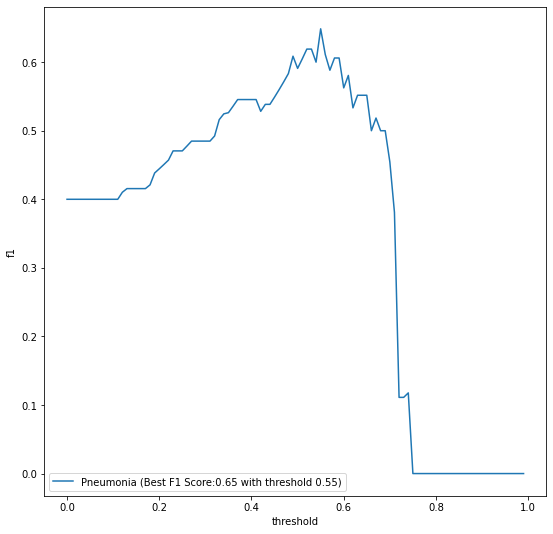

In [ ]:
pred_Y_f80_1 = my_model_f80_1.predict(valX3, batch_size = 32, verbose = True)

## plot figures
t_y = valY3
p_y = pred_Y_f80_1

plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

In [ ]:
# same as above; increase epochs = 50
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen3 = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen3 = make_val_gen(val_df, IMG_SIZE)

valX3, valY3 = val_gen3.next()

for layer in vgg_model.layers[0:17]:
    layer.trainable = False

my_model_f80_2 = build_my_model1(vgg_model)

counter = Counter(train_gen3.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}                     

my_model_f80_2.fit_generator(train_gen3, 
                       validation_data = (valX3, valY3), 
                       class_weight=class_weights,
                       epochs = 50)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
Epoch 1/50
36/36 [==============================] - 65s 2s/step - loss: 0.6856 - binary_accuracy: 0.5489 - val_loss: 0.6905 - val_binary_accuracy: 0.5312
Epoch 2/50
36/36 [==============================] - 61s 2s/step - loss: 0.6742 - binary_accuracy: 0.5808 - val_loss: 0.6755 - val_binary_accuracy: 0.5469
Epoch 3/50
36/36 [==============================] - 61s 2s/step - loss: 0.6660 - binary_accuracy: 0.5908 - val_loss: 0.6445 - val_binary_accuracy: 0.6250
Epoch 4/50
36/36 [==============================] - 62s 2s/step - loss: 0.6653 - binary_accuracy: 0.6009 - val_loss: 0.6437 - val_binary_accuracy: 0.6094
Epoch 5/50
36/36 [==============================] - 61s 2s/step - loss: 0.6557 - binary_accuracy: 0.6127 - val_loss: 0.6691 - val_binary_accuracy: 0.5625
Epoch 6/50
36/36 [==============================] - 61s 2s

64/64 [==============================] - 1s 10ms/step


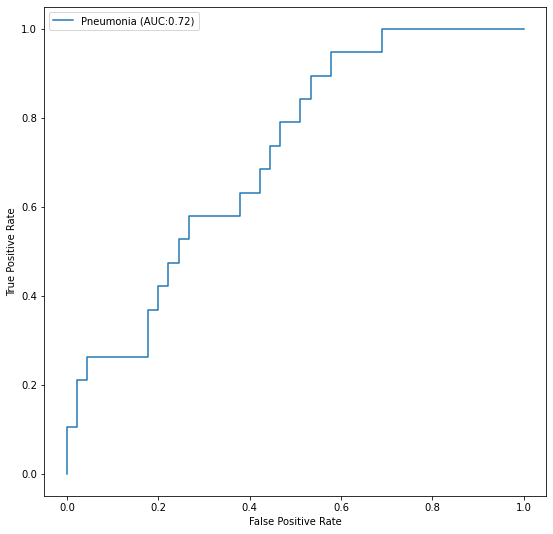

F1 score: [0.55072464 0.52941176 0.53731343 0.54545455 0.55384615 0.5625
 0.57142857 0.5483871  0.55737705 0.56666667 0.54237288 0.55172414
 0.52631579 0.53571429 0.54545455 0.51851852 0.52830189 0.5
 0.50980392 0.48       0.48979592 0.5        0.46808511 0.47826087
 0.48888889 0.5        0.51162791 0.52380952 0.48780488 0.5
 0.46153846 0.47368421 0.43243243 0.44444444 0.4        0.41176471
 0.36363636 0.3125     0.32258065 0.33333333 0.34482759 0.35714286
 0.37037037 0.38461538 0.32       0.33333333 0.26086957 0.18181818
 0.19047619 0.1        0.        ]


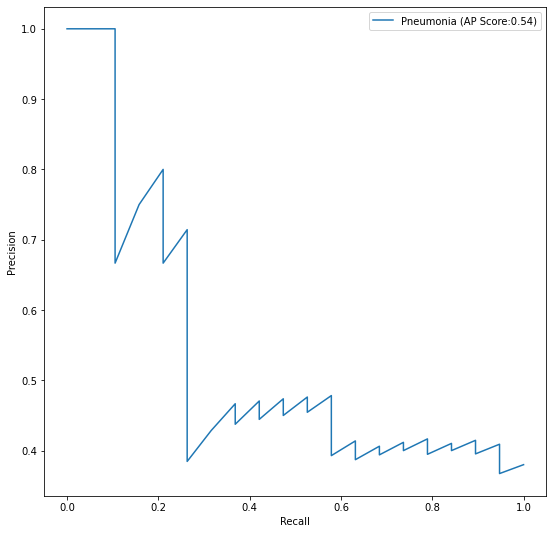

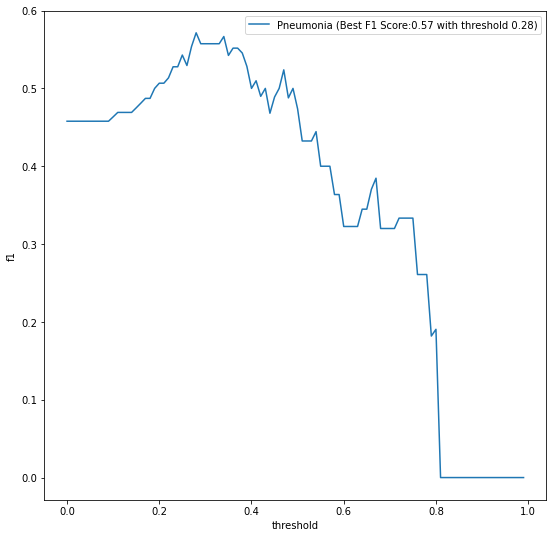

In [ ]:
pred_Y_f80_2 = my_model_f80_2.predict(valX3, batch_size = 32, verbose = True)

t_y = valY3
p_y = pred_Y_f80_2

## plot figures
plot_auc(t_y, p_y)
plot_pr(t_y, p_y)
plot_f1(t_y, p_y)

Based on the losses, AUC, AP, and F1 scores of the different models, my_model_f80_1 is the best model with the following parameters:
* VGG16 (freeze layers [0:17])
* Adam optimizer, learning rate  =  1e-4
* epochs  =  25

and the following scores:
* AUC: 0.84
* AP: 0.64
* F1: 0.65 with threshold 0.55

The augmentations applied to the training dataset were:
* rescale = 1. / 255.0
* horizontal_flip  =  True,
* vertical_flip  =  False, 
* height_shift_range =  0.1,
* width_shift_range = 0.1, 
* rotation_range = 5, 
* shear_range  =  0.1,
* zoom_range = 0.25

## EXTRA: Remove VGG16 layers 
freeze layers [0:16] instead of [0:17]

In [ ]:
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen = make_val_gen(val_df, IMG_SIZE)

valX, valY = val_gen.next()

for layer in vgg_model.layers[0:16]:
    layer.trainable = False

for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

my_model_f16 = build_my_model1(vgg_model)

my_model_f16.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Epoch 1/10
36/36 [==============================] - 64s 2s/step - loss: 0.6931 - binary_accuracy: 0.4996 - val_loss: 0.6931 - val_binary_accuracy: 0.7031
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6931 - binary_accuracy: 0.5004 - val_loss: 0.6931 - val_binary_accuracy: 0.7031
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.6931 - binary_accuracy: 0.4821 - val_loss: 0.6931 - val_binary_accuracy: 0.7031
Epoch 4/10
36/36 

freeze layers [0:15]

In [ ]:
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen = make_val_gen(val_df, IMG_SIZE)

valX, valY = val_gen.next()

for layer in vgg_model.layers[0:15]:
    layer.trainable = False

for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

my_model_f15 = build_my_model1(vgg_model)

my_model_f15.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 0.6905 - binary_accuracy: 0.5323 - val_loss: 0.6635 - val_binary_accuracy: 0.6719
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6846 - binary_accuracy: 0.5563 - val_loss: 0.6856 - val_binary_accuracy: 0.5469
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.6794 - binary_accuracy: 0.5878 - val_loss: 0.6793 - val_binary_accuracy: 0.5469
Epoch 4/10
36/36 

freeze layers [0:14]

In [ ]:
train_df, val_df = create_splits(all_xray_df, 'Pneumonia', val_pct=0.8)

IMG_SIZE = (224, 224) 

train_gen = make_train_gen_eight_aug(train_df, IMG_SIZE)
val_gen = make_val_gen(val_df, IMG_SIZE)

valX, valY = val_gen.next()

for layer in vgg_model.layers[0:14]:
    layer.trainable = False

for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

my_model_f14 = build_my_model1(vgg_model)

my_model_f14.fit_generator(train_gen, 
                       validation_data = (valX, valY), 
                       epochs = 10)

% pneumonia in train: 0.5
% pneumonia in val: 0.2
Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.
input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True
Epoch 1/10
36/36 [==============================] - 65s 2s/step - loss: 0.6912 - binary_accuracy: 0.5354 - val_loss: 0.6458 - val_binary_accuracy: 0.7031
Epoch 2/10
36/36 [==============================] - 60s 2s/step - loss: 0.6786 - binary_accuracy: 0.5751 - val_loss: 0.6457 - val_binary_accuracy: 0.6719
Epoch 3/10
36/36 [==============================] - 60s 2s/step - loss: 0.6701 - binary_accuracy: 0.5825 - val_loss: 0.6289 - val_binary_accuracy: 0.6719
Epoch 4/10
36/36 